In [2]:
pip install tensorflow


  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.74.0-cp313-cp313-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached ml_dtypes-0.5.3-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn import metrics
from tensorflow.keras import layers
import joblib

In [4]:
# Transformer Encoder Definition
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Normalization and Multi-Head Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Network
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

In [5]:
short_cols = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
       'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet', 'ExoplanetCandidate']

In [7]:
# Load and Prepare Data
data = pd.read_csv('KOI_cumulative_2025.07.31_21.17.09.csv', comment='#')
data['ExoplanetCandidate'] = data['koi_disposition'].apply(lambda x: 1 if x == 'CANDIDATE' or x == 'CONFIRMED' else 0)
data = data[short_cols]
data = data.dropna()

data.to_csv('KOI_2025.07.31_cleaned.csv', index=False)

# Define the feature columns and label
feature_columns = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet']
label_column = 'ExoplanetCandidate'

# Split the data into features and labels
X = data[feature_columns].values
y = data[label_column].values

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2)

# Normalize Features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Save the scaler
joblib.dump(scaler, "scaler_transformer.pkl")

# Reshape Data for Transformer (3D Input)
x_train = tf.expand_dims(x_train, axis=-1)  # Shape: (batch_size, num_features, 1)
x_test = tf.expand_dims(x_test, axis=-1)

# Build Model with Transformer Encoder and Dense Layers
input_shape = (x_train.shape[1], 1)  # num_features, 1

In [8]:
inputs = layers.Input(shape=input_shape)
x = transformer_encoder(inputs, head_size=32, num_heads=2, ff_dim=64, dropout=0.1)
x = layers.Flatten()(x)  # Flatten Transformer Output
x = layers.Dense(32)(x)
x = layers.LayerNormalization(axis=-1, center=True, scale=True)(x)
x = layers.Dense(16, activation='relu')(x)  # Used to be ReLU
x = layers.Dense(8, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

In [9]:
model = tf.keras.Model(inputs, outputs)

# Compile Model
model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 1)     │          2 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │        449 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 64)    │        128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 64)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 1)     │         65 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 1)     │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10)        │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        352 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32)        │         64 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │        136 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │          9 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,735 (6.78 KB)

 Trainable params: 1,735 (6.78 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
best_loss = 1983252378921
for i in range(1):
    # Train Model
    fitModel = model.fit(
        x_train, y_train, 
        epochs=200, batch_size=8, 
        validation_data=(x_test, y_test), 
        verbose=1
    )

    # Save History for Plotting
    history = fitModel.history
    with open('history.pkl', 'wb') as file:
        pickle.dump(history, file)

    if history['val_loss'][-1] < best_loss:
        best_loss = history['val_loss'][-1]
        model.save('NNmodel.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/200
918/918 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7475 - loss: 0.5138 - val_accuracy: 0.7723 - val_loss: 0.4660
Epoch 2/200
918/918 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7873 - loss: 0.4490 - val_accuracy: 0.7919 - val_loss: 0.4458
Epoch 3/200
918/918 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7943 - loss: 0.4336 - val_accuracy: 0.7947 - val_loss: 0.4325
Epoch 4/200
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7991 - loss: 0.4242 - val_accuracy: 0.7941 - val_loss: 0.4279
Epoch 5/200
918/918 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8040 - loss: 0.4186 - val_accuracy: 0.7952 - val_loss: 0.4225
Epoch 6/200
918/918 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8035 - loss: 0.4140 - val_accuracy: 0.8012 - val_loss: 0.4134
Epoch 7/200
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8047 - loss: 0.4104 - val_accuracy: 0.7990 - val_loss: 0.4109
Epoch 8/200
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8084 - loss: 0.4085 - val_ac

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8181 - loss: 0.3818 
Test Loss: 0.38183775544166565, Test Accuracy: 0.8180828094482422


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
F1 Score: 0.8313131313131313
Recall: 0.863588667366212
Precision: 0.801363193768257


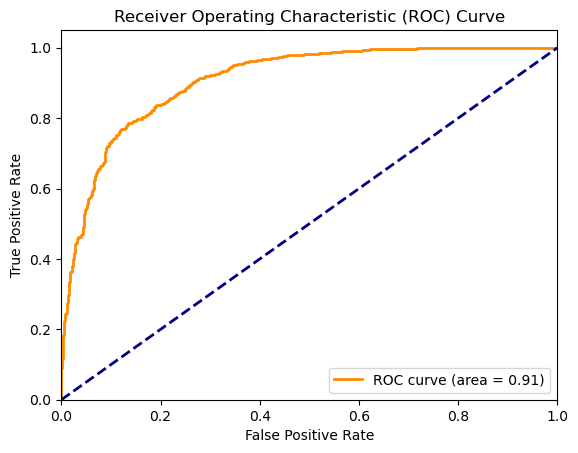

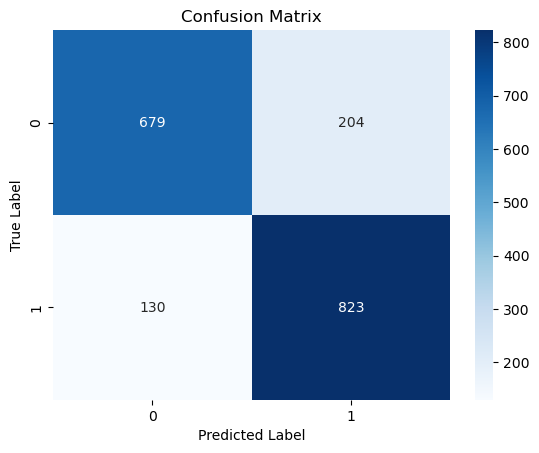

Model saved as transformer_model.h5


In [11]:
# Predict on the test set
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Compute F1 score, recall and precision
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")

# Compute and plot AUC and ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Save the final model for prediction
model.save('transformer_model.h5')
print("Model saved as transformer_model.h5")

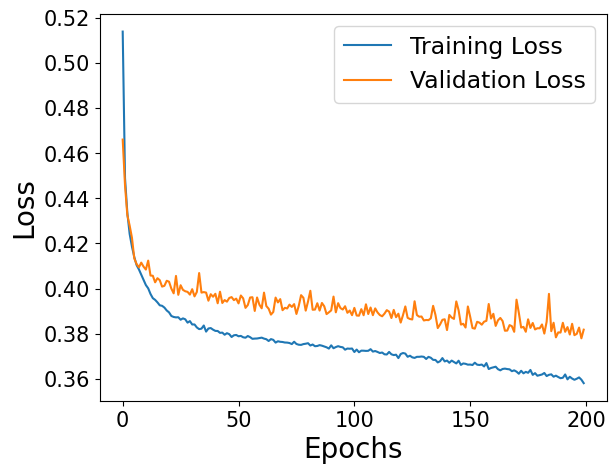

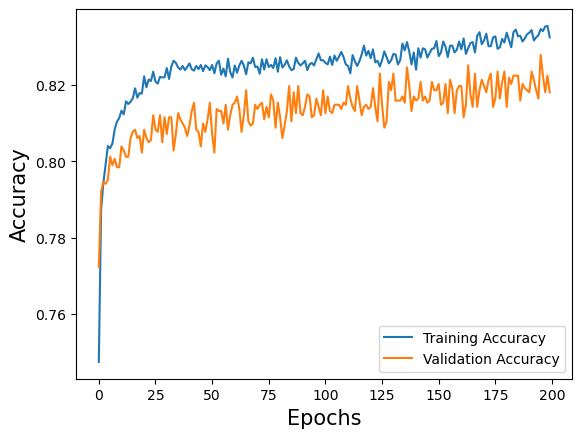

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

# Load history from a file
with open('history.pkl', 'rb') as file:
    history = pickle.load(file)

# Plot loss function over epochs
plt.figure()
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=20)  # Enlarge x-axis label font
plt.ylabel('Loss', fontsize=20)     # Enlarge y-axis label font
plt.legend(fontsize=17)

# Change the size of the numbers on both axes
plt.tick_params(axis='both', which='major', labelsize=15)  # Adjust `labelsize` as needed

# Automatically adjust subplot to fit in figure
plt.tight_layout()

# Save to PDF (ensure everything fits)
plt.savefig('Loss_Function_Over_Epochs.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Plot accuracy over epochs
plt.figure()
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.savefig('Accuracy Over Epochs.pdf')
plt.show()


In [13]:
# define an evaluation function and plot confusion matrix
def evaluation(y_true, y_pred, plot=True, quiet=False):

    accuracy, recall, f1, precision = metrics.accuracy_score(y_test, y_pred), metrics.recall_score(y_test, y_pred), \
                                        metrics.f1_score(y_test, y_pred), metrics.precision_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if not quiet:
        # Print Accuracy, Recall, F1 Score, and Precision metrics.
        print('Evaluation Metrics:')
        print('Accuracy: ' + str(accuracy))
        print('Recall: ' + str(recall))
        print('F1 Score: ' + str(f1))
        print('Precision: ' + str(precision))

        # Print Confusion Matrix
        print('\nConfusion Matrix:')
        print(' TN,  FP, FN, TP')
        print(confusion_matrix(y_true, y_pred).ravel())
    
    if plot:
        # plt.figure(figsize=(13,10))
        # plt.subplot(221)
        sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="viridis", fmt = "d", linecolor="k", linewidths=3)
        plt.title("CONFUSION MATRIX",fontsize=20)
        plt.xlabel("Truth", fontsize=16)
        plt.ylabel("Prediction", fontsize=16)
        plt.savefig('CONFUSION MATRIX.pdf')
        plt.show()
      

    return [accuracy, recall, f1, precision, tn, fp, fn, tp]

32/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

C:\Users\huangm\AppData\Local\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Evaluation Metrics:
Accuracy: 0.818082788671024
Recall: 0.863588667366212
F1 Score: 0.8313131313131313
Precision: 0.801363193768257

Confusion Matrix:
 TN,  FP, FN, TP
[679 204 130 823]


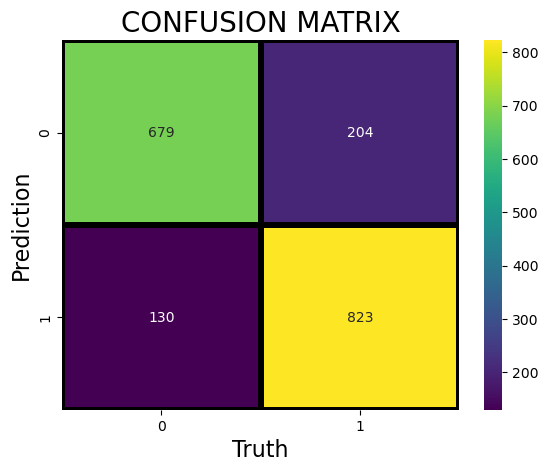

[0.818082788671024,
 0.863588667366212,
 0.8313131313131313,
 0.801363193768257,
 np.int64(679),
 np.int64(204),
 np.int64(130),
 np.int64(823)]

In [14]:
# Custom layer to wrap tf.reduce_mean
class ReduceMeanLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)
    
# SAVING A NEW MODEL
model.save('transformer_model.keras')

# LOADING OLD MODEL
loaded_model = tf.keras.models.load_model('transformer_model.keras', custom_objects={'ReduceMeanLayer': ReduceMeanLayer})

# Recompile the model with the desired optimizer
loaded_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

y_pred = loaded_model.predict(x_test).flatten()
y_pred = (y_pred_prob > 0.5).astype("int32")

# Assuming you have an evaluation function defined
evaluation(y_test, y_pred)

In [ ]:
# Check the shapes of X_test and y_test
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# Make predictions
y_pred = loaded_model.predict(x_test).flatten()

# Check the shape of y_pred
print("y_pred shape:", y_pred.shape)

In [ ]:
print("Label Distribution:", np.bincount(y_train))

In [ ]:
x_test_np.shape